# Over-sampling with cross-validation
When we train a classifier, we want it to predict an outcome in a real life dataset. The real datasets, most likely, also have a class imbalance. Thus, it is important to evaluate the performance of the classifier, on a data set with the same distribution of classes, as the one we expect in real life.

This means, that the over-sampling methods should be performed on the dataset that we are going to use to train the classifier. But, the performance of the model should be determined on a portion of the data, that was not re-sampled.

In this notebook, we will use the imbalanced-learn pipeline, to set up various over-sampling solutions, in a way that we train the model on re-sampled data, but we evaluate performance on non-resampled data.

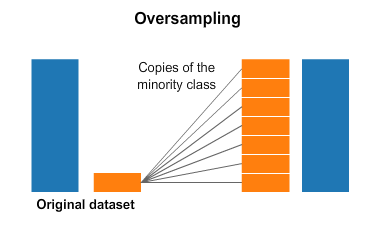

In [1]:
#Load the librarys
import pandas as pd #To work with dataset
import numpy as np #Math library
import matplotlib.gridspec as gridspec
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn
import warnings
# Preparation  
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer, StandardScaler,Normalizer,RobustScaler,MaxAbsScaler,MinMaxScaler,QuantileTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import KBinsDiscretizer
# Import StandardScaler from scikit-learn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer,IterativeImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import make_column_transformer,ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline,FeatureUnion
from sklearn.manifold import TSNE
# Import train_test_split()
# Metrics
from sklearn.metrics import roc_auc_score, average_precision_score,recall_score
from sklearn.metrics import make_scorer,mean_absolute_error
from sklearn.metrics import mean_squared_error,classification_report,f1_score
from sklearn.metrics import roc_curve,confusion_matrix
from yellowbrick.classifier import (
    ClassificationReport,
    DiscriminationThreshold,
)
from datetime import datetime, date
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.linear_model import LogisticRegression

#import tensorflow as tf 
#from tensorflow.keras import layers
#from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.callbacks import LearningRateScheduler
#import smogn
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone,ClassifierMixin
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
# For training random forest model
import lightgbm as lgb
from scipy import sparse
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
# Model selection
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression,f_classif,chi2
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import mutual_info_classif,VarianceThreshold

from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
# Imbalanced data 
from imblearn.datasets import fetch_datasets
# to correctly set up the cross-validation
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import (
    RandomUnderSampler,
    CondensedNearestNeighbour,
    TomekLinks,
    OneSidedSelection,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    NeighbourhoodCleaningRule,
    NearMiss,
    InstanceHardnessThreshold
)
from imblearn.over_sampling import (
    RandomOverSampler,
    SMOTE,
    ADASYN,
    BorderlineSMOTE,
    SVMSMOTE,
)


from lightgbm import LGBMClassifier
import lightgbm as lgbm
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from xgboost import XGBClassifier,XGBRegressor
from sklearn import set_config
from itertools import combinations
# Cluster :
from sklearn.cluster import MiniBatchKMeans
#from yellowbrick.cluster import KElbowVisualizer
#import smong 
import category_encoders as ce
import warnings
#import optuna 
from joblib import Parallel, delayed
import joblib 
from sklearn import set_config
from typing import List, Optional, Union
set_config(display='diagram')
warnings.filterwarnings('ignore')


# Load the data

In [2]:
%%time 
train = pd.read_csv('../input/GiveMeSomeCredit/cs-training.csv')
test = pd.read_csv('../input/GiveMeSomeCredit/cs-test.csv')
train.head(3)

CPU times: user 223 ms, sys: 69.6 ms, total: 292 ms
Wall time: 417 ms


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0


# 1-Preprocessing

## Convert Dtypes :

In [3]:
# Convert Dtypes :
train[train.select_dtypes(['int64','int16','float16','float32','float64','int8']).columns] = train[train.select_dtypes(['int64','int16','float16','float32','float64','int8']).columns].apply(pd.to_numeric)
train[train.select_dtypes(['object','category']).columns] = train.select_dtypes(['object','category']).apply(lambda x: x.astype('category'))
# Convert Dtypes :
test[test.select_dtypes(['int64','int16','float16','float32','float64','int8']).columns] = test[test.select_dtypes(['int64','int16','float16','float32','float64','int8']).columns].apply(pd.to_numeric)
test[test.select_dtypes(['object','category']).columns] = test.select_dtypes(['object','category']).apply(lambda x: x.astype('category'))

# Imbalanced target



In [4]:
train.SeriousDlqin2yrs.value_counts() / len(train)

0    0.93316
1    0.06684
Name: SeriousDlqin2yrs, dtype: float64

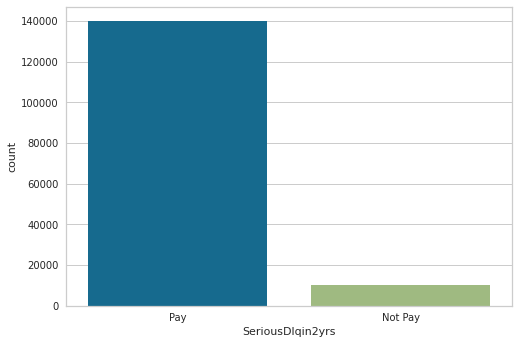

In [5]:
# visualize the target variable
g = sns.countplot(train['SeriousDlqin2yrs'])
g.set_xticklabels(['Pay','Not Pay'])
plt.show()

## Reduce Memory

In [6]:
# Author : https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        name =df[col].dtype.name 
        
        if col_type != object and col_type.name != 'category':
        #if name != "category":    
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
train= reduce_mem_usage(train)
test= reduce_mem_usage(test)

Memory usage of dataframe is 13.73 MB
Memory usage after optimization is: 3.29 MB
Decreased by 76.0%
Memory usage of dataframe is 9.29 MB
Memory usage after optimization is: 2.90 MB
Decreased by 68.7%


## X and Y

In [7]:
# Cardinality : 
# - RevolvingUtilizationOfUnsecuredLines :125728, high Outlier
# - DebtRatio :114194 , high Outlier 
# deal with outlier + bin 
PERCENTAGE = ["RevolvingUtilizationOfUnsecuredLines", "DebtRatio"]
# MonthlyIncome:13594 , high outlier +bin 
REAL= ["MonthlyIncome"]
# Can be considred as cat 
NUMERIC_DISCRET_low = ["NumberOfDependents",
                       "NumberOfTime60-89DaysPastDueNotWorse",
                       "NumberRealEstateLoansOrLines",
                       "NumberOfTimes90DaysLate",
                       "NumberOfOpenCreditLinesAndLoans",
                       "NumberOfTime30-59DaysPastDueNotWorse",
                       "age"]
Late_Pay_Cols = ['NumberOfTime30-59DaysPastDueNotWorse',
                 'NumberOfTimes90DaysLate',
                 'NumberOfTime60-89DaysPastDueNotWorse']
TARGET = ["SeriousDlqin2yrs"]

#also change the type for TARGET to categorical
#df[TARGET] = df[TARGET].astype('category')

In [8]:
y = train['SeriousDlqin2yrs']

## Imput before Descritaziation : 

### IterativeImputer


In [9]:
%%time 
param =  {   "verbosity": 0,
            #"objective": "binary:logistic",
            #"eval_metric": "auc",
            'random_state': 42,
            # regression
            'objective':'reg:squarederror', 
             'eval_metric': 'mae',
            #early_stopping_rounds=100 ,
            'gpu_id':0, 
            'predictor':"gpu_predictor",
            # use exact for small dataset.
            #"tree_method": "exact",
            # big data :
             'tree_method': 'gpu_hist',
            # defines booster, gblinear for linear functions.
             'booster': 'gbtree', 
            'lambda': 8.544792472633987e-07,
            'alpha': 0.31141671752487043,
            'subsample': 0.8779467596981366, 
            'colsample_bytree': 0.9759532762677546,
            'learning_rate': 0.008686087328805853, 
            'n_estimators': 6988,
            'max_depth': 9,
            'min_child_weight': 2, 
            'eta': 3.7603213457541647e-06,
            'gamma': 2.1478058456847449e-07,
            'grow_policy': 'lossguide'}
                

#model_xgb = XGBRegressor(
       #objective="mae",
 #   **xgb_params2)

numeric_transformer1 = Pipeline(
                            steps=[
                            ('imputer', SimpleImputer(strategy='median'
                                                      ,add_indicator=True)),
                            ('scaler', PowerTransformer()),#(Numerical Input, Numerical Output)
                            # Create an SelectKBest object to select features with two best ANOVA F-Values
                            #The F-value scores examine if, when we group the numerical feature by the target vector, the means for each group are significantly different
                           # ('reducedim',  SelectPercentile(f_classif,percentile=90))
                            ]
                            )
numeric_transformer2 = Pipeline(
                            steps=[
                            #('imputer', SimpleImputer(strategy='median'
                             #                         ,add_indicator=True)),
                            ('scaler', PowerTransformer()),#(Numerical Input, Numerical Output)
                            # Create an SelectKBest object to select features with two best ANOVA F-Values
                            #The F-value scores examine if, when we group the numerical feature by the target vector, the means for each group are significantly different
                           # ('reducedim',  SelectPercentile(f_classif,percentile=90))
                            ]
                            )

pipe_xgbr1 = Pipeline(
                    steps=[
                        ('preprocessor', numeric_transformer1),
                        ('classifier', XGBRegressor(
                      #objective="mae",
                       **param))
                    ]
                )
pipe_xgbr2 = Pipeline(
                    steps=[
                        ('preprocessor', numeric_transformer2),
                        ('classifier', XGBRegressor(
                      #objective="mae",
                       **param))
                    ]
                )

CPU times: user 358 µs, sys: 0 ns, total: 358 µs
Wall time: 363 µs


In [10]:
%%time 
train=train.drop(['Unnamed: 0','SeriousDlqin2yrs'], axis=1)
test=test.drop(['Unnamed: 0','SeriousDlqin2yrs'], axis=1)
train_final= pd.concat( [train, test], axis=0) 
#testdf_income= train_final[train_final['MonthlyIncome'].isnull()==True]
traindf_income = train_final[train_final['MonthlyIncome'].isnull()==False]
y_income = traindf_income['MonthlyIncome']
X_income=traindf_income.drop(["MonthlyIncome"],axis=1)
pipe_xgbr1.fit(X_income, y_income)
train_income_missing=train[train['MonthlyIncome'].isnull()==True].drop(["MonthlyIncome"],axis=1)
test_income_missing=test[test['MonthlyIncome'].isnull()==True].drop(["MonthlyIncome"],axis=1)
train_predicted = pipe_xgbr1.predict(train_income_missing)
test_predicted = pipe_xgbr1.predict(test_income_missing)
train.loc[(train.MonthlyIncome.isnull()), 'MonthlyIncome'] = train_predicted
test.loc[(test.MonthlyIncome.isnull()), 'MonthlyIncome'] = test_predicted

CPU times: user 2min 30s, sys: 3.25 s, total: 2min 33s
Wall time: 2min 36s


In [11]:
%%time 
traindf_NumberOfDependents = train_final[train_final['NumberOfDependents'].isnull()==False]
y_NumberOfDependents = traindf_NumberOfDependents['NumberOfDependents']
X_NumberOfDependents=traindf_NumberOfDependents.drop(["NumberOfDependents"],axis=1)
pipe_xgbr2.fit(X_NumberOfDependents, y_NumberOfDependents)
train_NumberOfDependents_missing=train[train['NumberOfDependents'].isnull()==True].drop(["NumberOfDependents"],axis=1)
test_NumberOfDependents_missing=test[test['NumberOfDependents'].isnull()==True].drop(["NumberOfDependents"],axis=1)
train_predicted = pipe_xgbr2.predict(train_NumberOfDependents_missing)
test_predicted = pipe_xgbr2.predict(test_NumberOfDependents_missing)
train.loc[(train.NumberOfDependents.isnull()), 'NumberOfDependents'] = train_predicted
test.loc[(test.NumberOfDependents.isnull()), 'NumberOfDependents'] = test_predicted

CPU times: user 2min 57s, sys: 1.34 s, total: 2min 59s
Wall time: 3min 1s


In [12]:
# Add bin data 
# initializing append_str
append_str = 'cat_'
# Append suffix / prefix to strings in list
num_features1=["RevolvingUtilizationOfUnsecuredLines", "DebtRatio","MonthlyIncome"]
num_features2=["NumberOfDependents",
                       "NumberOfTime60-89DaysPastDueNotWorse",
                       "NumberRealEstateLoansOrLines",
                       "NumberOfTimes90DaysLate",
                       "NumberOfOpenCreditLinesAndLoans",
                       "NumberOfTime30-59DaysPastDueNotWorse",
                       "age"]
cat_features1 = [append_str + sub for sub in num_features1]
cat_features2 = [append_str + sub for sub in num_features2]

# create the discretizer object with strategy quantile and 1000 bins
discretizer1 = KBinsDiscretizer(n_bins=40, encode='ordinal',strategy='quantile')
discretizer2 = KBinsDiscretizer(n_bins=4, encode='ordinal',strategy='quantile')

pipeline1 = Pipeline([
        ('imputer', SimpleImputer( strategy='median')),
        ('bin', discretizer1)
    ])
# fit the discretizer to the train set
pipeline1.fit(train.loc[:,num_features1])
# apply the discretisation
train_cat1 = pipeline1.transform(train.loc[:,num_features1])
test_cat1 = pipeline1.transform(test.loc[:,num_features1])
train_df1=pd.DataFrame(train_cat1,columns=cat_features1).astype('category')
test_df1=pd.DataFrame(test_cat1,columns=cat_features1).astype('category')
train_final1= pd.concat( [train.loc[:,num_features1], train_df1], axis=1) 
test_final1= pd.concat( [test.loc[:,num_features1], test_df1], axis=1) 

pipeline2 = Pipeline([
        ('imputer', SimpleImputer( strategy='median')),
        ('bin', discretizer2)
    ])
# fit the discretizer to the train set
pipeline2.fit(train.loc[:,num_features2])
# apply the discretisation
train_cat2 = pipeline2.transform(train.loc[:,num_features2])
test_cat2 = pipeline2.transform(test.loc[:,num_features2])
train_df2=pd.DataFrame(train_cat2,columns=cat_features2).astype('category')
test_df2=pd.DataFrame(test_cat2,columns=cat_features2).astype('category')
train_final2= pd.concat( [train.loc[:,num_features2], train_df2], axis=1) 
test_final2= pd.concat( [test.loc[:,num_features2], test_df2], axis=1) 

In [13]:
train_final= pd.concat( [train_final1, train_final2], axis=1) 
test_final= pd.concat( [test_final1, test_final2], axis=1) 

## Final X and y

In [14]:
# Pour le train test
target= "SeriousDlqin2yrs"
X = train_final# axis=1
X_test_final =test_final# axis=1

In [15]:
X_test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 20 columns):
 #   Column                                    Non-Null Count   Dtype   
---  ------                                    --------------   -----   
 0   RevolvingUtilizationOfUnsecuredLines      101503 non-null  float16 
 1   DebtRatio                                 101503 non-null  float32 
 2   MonthlyIncome                             101503 non-null  float32 
 3   cat_RevolvingUtilizationOfUnsecuredLines  101503 non-null  category
 4   cat_DebtRatio                             101503 non-null  category
 5   cat_MonthlyIncome                         101503 non-null  category
 6   NumberOfDependents                        101503 non-null  float16 
 7   NumberOfTime60-89DaysPastDueNotWorse      101503 non-null  int8    
 8   NumberRealEstateLoansOrLines              101503 non-null  int8    
 9   NumberOfTimes90DaysLate                   101503 non-null  int8    
 10  NumberOf

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 20 columns):
 #   Column                                    Non-Null Count   Dtype   
---  ------                                    --------------   -----   
 0   RevolvingUtilizationOfUnsecuredLines      150000 non-null  float16 
 1   DebtRatio                                 150000 non-null  float32 
 2   MonthlyIncome                             150000 non-null  float32 
 3   cat_RevolvingUtilizationOfUnsecuredLines  150000 non-null  category
 4   cat_DebtRatio                             150000 non-null  category
 5   cat_MonthlyIncome                         150000 non-null  category
 6   NumberOfDependents                        150000 non-null  float16 
 7   NumberOfTime60-89DaysPastDueNotWorse      150000 non-null  int8    
 8   NumberRealEstateLoansOrLines              150000 non-null  int8    
 9   NumberOfTimes90DaysLate                   150000 non-null  int8    
 10  NumberOf

In [17]:
del train
del test 
del train_final
del test_final

In [18]:
# select non-numeric columns
cat_columns = X.select_dtypes(exclude=['int64','int16','float16','float32','float64','int8']).columns
cat_columns

Index(['cat_RevolvingUtilizationOfUnsecuredLines', 'cat_DebtRatio',
       'cat_MonthlyIncome', 'cat_NumberOfDependents',
       'cat_NumberOfTime60-89DaysPastDueNotWorse',
       'cat_NumberRealEstateLoansOrLines', 'cat_NumberOfTimes90DaysLate',
       'cat_NumberOfOpenCreditLinesAndLoans',
       'cat_NumberOfTime30-59DaysPastDueNotWorse', 'cat_age'],
      dtype='object')

### Num Features



In [19]:
# select the float columns
num_columns = X.select_dtypes(include=['int64','int16','float16','float32','float64','int8']).columns
num_columns

Index(['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome',
       'NumberOfDependents', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberRealEstateLoansOrLines', 'NumberOfTimes90DaysLate',
       'NumberOfOpenCreditLinesAndLoans',
       'NumberOfTime30-59DaysPastDueNotWorse', 'age'],
      dtype='object')

# FE

In [20]:
class MiniKmeansTransformerEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, num_clusters = 11, encoder=ce.woe.WOEEncoder()):
        self.num_clusters = num_clusters
        self.encoder= encoder
        if self.num_clusters > 0:
            self.kmeans = MiniBatchKMeans(n_clusters=self.num_clusters, random_state=0)
    
    def fit(self, X, y=None):
        if self.num_clusters > 0:
            self.kmeans.fit(X)
            preds=self.kmeans.predict(X)
            preds=pd.DataFrame(preds, columns=['kmeans']).astype('category')
            self.encoder.fit(preds,y)
        return self
    
    def transform(self, X, y=None):
        pred_classes = self.kmeans.predict(X)
        pred_classes=pd.DataFrame(pred_classes, columns=['kmeans']).astype('category')
        pred_encoded = self.encoder.transform(pred_classes)
        return np.hstack((X, pred_encoded))
        #return pred_encoded

# Complete Pipe 

1. Features Engineer

1. Kmeans

1. Sparse

1. Poly

1. Scaler/Transformer

1. imput

1. Add bin data 

## Pipe : 


In [21]:
# Cat pipeline
categorical_transformer = Pipeline(
                    steps=[
                        ('imputer', SimpleImputer(strategy='most_frequent',
                                                  fill_value='missing',
                                                  add_indicator=True)),
                        ('encoder',  ce.woe.WOEEncoder()),#(Numerical Input, Categorical Output)
                        #('sparse_features', SparseInteractions(degree=2)),
                        #('reducedim',  SelectPercentile( mutual_info_classif, percentile=90))

                    ]
                    ) 
#Define vnum pipeline
numeric_transformer = Pipeline(
                            steps=[
                            ('imputer', SimpleImputer(strategy='median'
                                                      ,add_indicator=True)),
                            #('general_features',FeaturesEngineer()),
                            ('scaler', PowerTransformer()),#(Numerical Input, Numerical Output)
                            # Create an SelectKBest object to select features with two best ANOVA F-Values
                            #The F-value scores examine if, when we group the numerical feature by the target vector, the means for each group are significantly different
                            ('kmeans',MiniKmeansTransformerEncoder()),
                            ('polynominal_features', PolynomialFeatures(degree=2)),
                            #('reducedim',  SelectPercentile(f_classif,percentile=90))
                            ]
                            )
# Features union cat + num 
# WOE+PowerTransformer
preprocessor_woe_powertransformer = ColumnTransformer(
            transformers=[
                ('numerical', numeric_transformer, num_columns),
               # ('categorical', categorical_transformer, cat_columns)
            ])
#Define vnum pipeline
numeric_transformer_final = Pipeline(
                            steps=[
                            ('imputer', SimpleImputer(strategy='median'
                                                      ,add_indicator=True)),
                            #('general_features',FeaturesEngineer()),
                            ('scaler', PowerTransformer()),#(Numerical Input, Numerical Output)
                            # Create an SelectKBest object to select features with two best ANOVA F-Values
                            #The F-value scores examine if, when we group the numerical feature by the target vector, the means for each group are significantly different
                            ('kmeans',MiniKmeansTransformerEncoder()),
                            ('polynominal_features', PolynomialFeatures(degree=2)),
                            ('reducedim',  SelectPercentile(f_classif,percentile=95))
                            ]
                            )
# Features union cat + num 
# WOE+PowerTransformer
preprocessor_woe_powertransformer_final = ColumnTransformer(
            transformers=[
                ('numerical', numeric_transformer_final, num_columns),
               # ('categorical', categorical_transformer, cat_columns)
            ])

In [22]:
lgbm_param2={'learning_rate': 0.0018069834369607075,
                                 'max_depth': 8,
                                 #'max_features': 4,
                                 'min_samples_leaf': 47,
                                 #'min_samples_split': 389,
                                 'subsample': 0.8573598985000007,
                                 #'n_iter_no_change': 300,
                                 'n_estimators': 5000,
                                 'verbose': -1,
                                 'random_state': 42,
                                 'metric': 'auc',
                                "device_type" : "gpu",
                                'boosting_type': 'gbdt',
                                #'tree_method': "gpu_hist"
                               }

model_lgbm2 = lgbm.LGBMClassifier(**lgbm_param2,
                              # use it  only on gpu
                            # rsm=np.nan
                              #cat_features=cat_features
                             )
pipe1_model_lgbm_woe_powertransformer2 = Pipeline(
    steps=[
        ('preprocessor', preprocessor_woe_powertransformer),
         ('reducedim',  SelectPercentile( f_classif, percentile=95)),
        # ('dim_red', SelectKBest(f_regression, k=20)),
        #('Sparseinteractions', SparseInteractions(degree=2)),
         #('PolynomialFeatures', PolynomialFeatures(degree=2)),
        #('PCAreducer', PCA(n_components=0.8)),
        ('classifier',model_lgbm2)
    ]
)
pipe1_model_lgbm_woe_powertransformer2

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('scaler',
                                                                   PowerTransformer()),
                                                                  ('kmeans',
                                                                   MiniKmeansTransformerEncoder()),
                                                                  ('polynominal_features',
                                                                   PolynomialFeatures())]),
                                                  Index(['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome'...
       'NumberOfOpenCreditLinesAndLoans',
       'NumberOfTime30-59DaysPastDueNotWorse', 'age'],
      dtype='object'))])),
                ('reducedim', SelectPercentile(percentile=95)),
                ('classifier',
                 LGBMClassifier(device_type='gpu',
                                learning_rate=0.0018069834369607075,
                                max_depth=8, metric='auc', min_samples_leaf=47,
                                n_estimators=5000, random_state=42,
                                subsample=0.8573598985000007, verbose=-1))])

#  Train_Test

In [23]:
###############################################################################
#                                  Get data                                 #
###############################################################################
X_train,X_test, y_train,  y_test = train_test_split(X, y,stratify=y, 
                                                       test_size=0.25,
                                                        random_state=42,
                                                        shuffle=True)

In [24]:
preprocessor_woe_powertransformer_final.fit(X_train,y_train)
X_train_pre = preprocessor_woe_powertransformer_final.transform(X_train)
X_test_pre = preprocessor_woe_powertransformer_final.transform(X_test)
#del x_final
#del x_test_final

# 1-Simple train : 

## Full classification report


        Precision, Recall, F-measure, Support

        Precision = tp / (tp + fp)

        Recall = tp / (tp + fn)

        F1 = 2 (precision recall) / (precision + recall)

        Support = Number of cases on each class

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=47. Current value: min_data_in_leaf=47


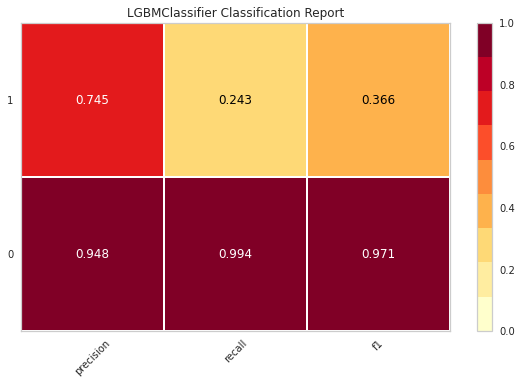

<AxesSubplot:title={'center':'LGBMClassifier Classification Report'}>

In [25]:
#https://www.scikit-yb.org/en/latest/api/classifier/classification_report.html
visualizer = ClassificationReport(model_lgbm2)
visualizer.fit(X_train_pre,y_train)        # Fit the visualizer and the model
visualizer.score(X_train_pre,y_train)        # Evaluate the model on the test data
visualizer.show() 

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=47. Current value: min_data_in_leaf=47


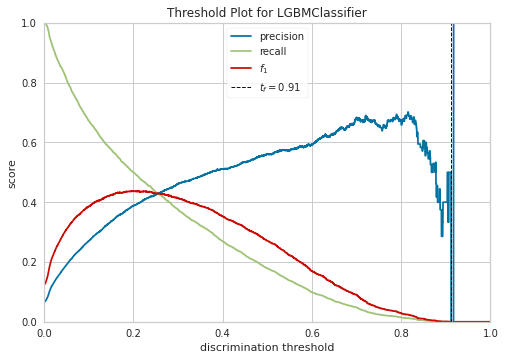

<AxesSubplot:title={'center':'Threshold Plot for LGBMClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [26]:
visualizer = DiscriminationThreshold(model_lgbm2,
                                     n_trials=1,
                                     cv=0.5,
                                     argmax='fscore',
                                     random_state=0,
                                     is_fitted='auto',
                                     exclude = "queue_rate")

visualizer.fit(X_train_pre,y_train)        # Fit the visualizer and the model
visualizer.score(X_train_pre,y_train)        # Evaluate the model on the test data
visualizer.show()

# Oversample

In [27]:
oversampler_dict = {

    'random': RandomOverSampler(
        sampling_strategy='auto',
        random_state=42),

    'smote': SMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=42,  # for reproducibility
        k_neighbors=5,
        n_jobs=4),

    'adasyn': ADASYN(
        sampling_strategy='auto',  # samples only the minority class
        random_state=42,  # for reproducibility
        n_neighbors=5,
        n_jobs=4),

    'border1': BorderlineSMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=42,  # for reproducibility
        k_neighbors=5,
        m_neighbors=10,
        kind='borderline-1',
        n_jobs=4),

    'border2': BorderlineSMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=42,  # for reproducibility
        k_neighbors=5,
        m_neighbors=10,
        kind='borderline-2',
        n_jobs=4),

    'svm': SVMSMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=42,  # for reproducibility
        k_neighbors=5,
        m_neighbors=10,
        n_jobs=4,
        svm_estimator=svm.SVC(kernel='linear')),
}

In [28]:
# function to train random forests and evaluate the performance

# ***with cross-validation***

def run_model(X_train, y_train, oversampler=None):
    
    # set up the classifier
    rf = model_lgbm2
    
    # set up a scaler 
    # (as the oversampling techniques use KNN
    # we put the variables in the same scale)
    scaler = MinMaxScaler()
    
    # without sampling:
    if not oversampler:

        model = rf
    
    # set up a pipeline with sampling:
    else:
        
        # important to scale before the re-sampler
        # as the many of methods require the variables in 
        # a similar scale
        model = make_pipeline(
            scaler,
            oversampler,
            rf,
        )
        
        
        
    # When we make a pipeline and then run the training of the model
    # with cross-validation, the procedure works as follows:
    
    # 1) take 2 of the 3 fold as train set
    # 2) resample the 2 fold (aka, the train set)
    # 3) train the model on the resampled data from point 2
    # 4) evaluate performance on the 3rd fold, that was not resampled
    
    # this way, we make sure that we are not evaluating the performance
    # of our classifier on the under-sampled data
    
    cv_results = cross_validate(
        model, # the lgbm model  or the pipeline
        X_train, # the data that will be used in the cross-validation
        y_train, # the target
        scoring="roc_auc", # the metric that we want to evaluate
        cv=5, # the cross-validation fold
    )

    print(
        'model_lgbm2 roc_auc: {0} +/- {1}'.format(
        cv_results['test_score'].mean(), cv_results['test_score'].std()
        )
    )
    return cv_results['test_score'].mean(), cv_results['test_score'].std()

In [29]:
# now we train several models, with the different under-samplers and
# with cross-validation
# to save the results
pr_mean_dict = {}
pr_std_dict = {} 
# initiate a dictionary per dataset
#pr_mean_dict[dataset] = {}
#pr_std_dict[dataset] = {}

# load dataset
#data = fetch_datasets()[dataset]

# separate dataset into train and test
#X_train, X_test, y_train, y_test = train_test_split(
 #   data.data,  
  #  data.target, 
   # test_size=0.3,
   # random_state=0,
#)


# train model on data without re-sampling
# with cross-validation
aps_mean, aps_std = run_model(X_train_pre, y_train)
 # store results
pr_mean_dict['full_data'] = aps_mean
pr_std_dict['full_data'] = aps_std
    
print()
for oversampler in oversampler_dict.keys():
    print(oversampler)
    # resample, train and evaluate performance
    # with cross-validation
    aps_mean, aps_std = run_model(X_train, y_train, oversampler_dict[oversampler])
     # store results
    pr_mean_dict[oversampler] = aps_mean
    pr_std_dict[oversampler] = aps_std
    print()
print()

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=47. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=47. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=47. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=47. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=47. Current value: min_data_in_leaf=47
model_lgbm2 roc_auc: 0.8627374534105787 +/- 0.002681755319299279

random
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=47. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_da

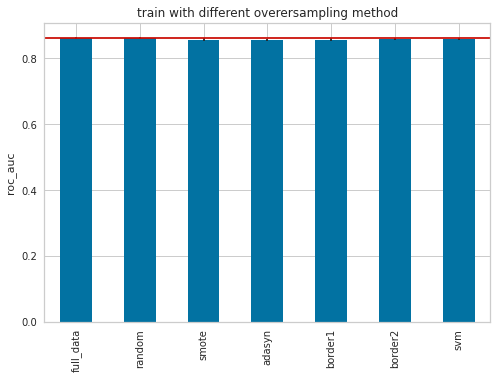

In [30]:
pr_mean_s = pd.Series(pr_mean_dict)
pr_std_s = pd.Series(pr_std_dict)
pr_mean_s.plot.bar(yerr=[pr_std_s, pr_std_s])
plt.title("train with different overersampling method")
plt.ylabel("roc_auc")
plt.axhline(pr_mean_dict['full_data'], color='r')
plt.show()

Different under-sampling techniques work best for different datasets.
ENN, RENN and AllKNN tend to produce similar results, so we may as well just choose one of the 3

In [31]:
%%time 
#pipe_woe_powertransformer.fit(X,y)
#x_pre = pipe_woe_powertransformer_red.transform(X)
#x_test_final_pre = pipe_woe_powertransformer_red.transform(X_test_final)
#del x_final
#del x_test_final
def plot_roc(y,y_pred):
    from sklearn.metrics import auc
    fpr, tpr, thresholds = roc_curve(y_true=y, y_score=y_pred)
    auc = auc(fpr, tpr)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Model(area = {:.3f})'.format(auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 9.06 µs


    %%time 
    # evaluate each strategy on the dataset
    results = list()
    # Setting a 10-fold stratified cross-validation (note: shuffle=True)
    SEED = 42
    FOLDS = 10
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
    # CV interations
    # Create arrays for the features and the response variable
    roc_auc = list()
    average_precision = list()
    #X1=X.iloc[0:2000,:].copy()
    #y1=y[0:2000].copy()
    oof = np.empty((X.shape[0],))
    #oof_bin = np.empty((X.shape[0],))
    predictions=[]
    mean_auc = 0
    mean_ap=0
    F1 = list()
    Recall=list()
    best_iteration = list()
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):    
        X_train, y_train = X.iloc[list(train_idx), :], y.iloc[list(train_idx)]
        X_test, y_test = X.iloc[list(test_idx), :],y.iloc[list(test_idx)]
        pipe1_model_lgbm_woe_powertransformer2.fit(X_train,y_train,
                                                      #classifier__verbose=False
                                                      #,verbose=False
                                                     )
        preds = pipe1_model_lgbm_woe_powertransformer2.predict_proba(X_test)[:,1]
        oof[test_idx] = preds
        auc_score= roc_auc_score(y_true=y_test, y_score=preds)
        roc_auc.append(auc_score)
        ap=average_precision_score(y_true=y_test, y_score=preds)
        plot_roc(y_test,preds)
        mean_auc += auc_score / FOLDS
        mean_ap+=ap/FOLDS
        predictions.append(pipe1_model_lgbm_woe_powertransformer2.predict_proba(X_test_final)[:,1]) 
        y_predicted = pipe1_model_lgbm_woe_powertransformer2.predict(X_test)
        recall = recall_score(y_test, y_predicted)
        f1= f1_score(y_test, y_predicted)
        print(f"Fold {fold} | AUC: {auc_score}")
        print(f"Fold {fold} | Avergae_precesion: {ap}")
        print(f"Fold {fold} | recall: {recall}")
        print(f"Fold {fold} | F1: {f1}")
        print('Classification report:\n',classification_report(y_test,y_predicted))
        print('Confusion_matrix:\n',confusion_matrix(y_test,y_predicted))
        roc_auc.append(auc_score)
        F1.append(f1)
        Recall.append(recall)
        #Mean of the predictions
    print('-' * 80)  
    print(f"\nOverall mean AUC score : {mean_auc}")
    print(f"\nOverall mean F1 score : {np.mean(F1)}")
    print(f"\nOverall mean average precision score : {mean_ap}")
    print(f"\nOverall mean recall score : {np.mean(Recall)}")

# Prepare data + undersample in all data

In [32]:
%%time 
#pipe_woe_powertransformer.fit(X,y)
#x_pre = pipe_woe_powertransformer_red.transform(X)
#x_test_final_pre = pipe_woe_powertransformer_red.transform(X_test_final)
#model = make_pipeline(
 #           scaler,
  #          undersampler,
   #         model_lgbm2,
    #    )
#rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
#x_rus, y_rus = rus.fit_resample(x, y)

#print('original dataset shape:', Counter(y))
#print('Resample dataset shape', Counter(y_rus))
#del x_final
#del x_test_final

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


In [33]:
#predictions.shape

In [34]:
#predictions

In [35]:
#predictions = np.mean(np.column_stack(predictions), axis=1)

    # Save the predictions to a CSV file
    sub = pd.read_csv('../input/GiveMeSomeCredit/sampleEntry.csv')
    sub['Probability']=predictions
    sub.to_csv('pipe1_model_lgbm_woe_powertransformer2_simple.csv', index=False)
    sub

# Conclusion: 

## Advantages and Disadvantage of over-sampling

**Advantages**

Unlike under-sampling, this method leads to no information loss.
Outperforms under sampling

**Disadvantages**

It increases the likelihood of overfitting since it replicates the minority class events.

credit: 

**Imbalanced:**

https://elitedatascience.com/imbalanced-classes

https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

https://github.com/DeepSparkChaker/machine-learning-imbalanced-data/tree/master/Section-04-Undersampling

https://github.com/DeepSparkChaker/machine-learning-imbalanced-data/blob/master/Section-04-Undersampling/04-12-Under-sampling-method-comparison-Precision-cross-val.ipynb

https://github.com/DeepSparkChaker/machine-learning-imbalanced-data/blob/master/Section-05-Oversampling/05-11-Over-sampling-with-cross-validation.ipynb

**stacking:**

https://towardsdatascience.com/stacking-classifiers-for-higher-predictive-performance-566f963e4840

https://www.dataquest.io/blog/introduction-to-ensembles/

https://scikit-learn.org/stable/modules/ensemble.html

https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/


https://mlfromscratch.com/model-stacking-explained/#/

http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/

http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/


https://www.kaggle.com/bannourchaker/7ensembling-stacking-averaging-scratchvssklearn/edit/run/73916270

https://www.kaggle.com/bannourchaker/averagingmodels

https://mlfromscratch.com/model-stacking-explained/#/

https://neptune.ai/blog/ensemble-learning-guide

https://www.analyticsvidhya.com/blog/2021/08/ensemble-stacking-for-machine-learning-and-deep-learning/

https://www.kaggle.com/prashant111/adaboost-classifier-tutorial

https://www.kaggle.com/bannourchaker/stacking/edit/run/75840835

https://www.kaggle.com/bannourchaker/8-ensembling-blending-scratchvsoop

**Bagging:**

https://vitalflux.com/bagging-classifier-python-code-example/

https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/

**complete guide Stacking :**

https://neptune.ai/blog/ensemble-learning-guide

https://www.analyticsvidhya.com/blog/2021/08/ensemble-stacking-for-machine-learning-and-deep-learning/

https://www.kaggle.com/prashant111/adaboost-classifier-tutorial